## Сегментация опухолей мозга с помощью UNet



### Загрузка данных
Данные представлены в виде питоновского словаря, где пары изображение-маска сохранены как .h5 файл, с ключами `image` и `mask`.

Датасет доступен по [ссылке](https://disk.yandex.ru/d/D_x_9woD55P8_g)

In [1]:
import numpy as np
import os
import h5py

# Directory containing .h5 files
path_to_data = 'data/'  # Change it accordingly 
directory = f'{path_to_data}BraTS2020_training_data/content/data'

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_205_slice_127.h5', 'volume_183_slice_134.h5', 'volume_82_slice_23.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.4399325706138475
Array min val: -0.532389590425846

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


## О данных
В нашема датасете снимки МРТ головного мозга вместе с маской, показывающий на абнормальные участки тканей головного мозга. У каждого изображения 4 канала

#### Каналы:
1) **T1-weighted (T1)**: Канал, хранящий в себе изображение структуры тканей головного мозга в высоком разрешении. Хорошо для визуализации структуры мозга, но не так чувствителен к тканям опухолей, как другие типы каналов.

2) **T1-weighted post contrast (T1c or T1Gd)**: После инъекции котрастного агента (обычно gadolinium), T1-weighted изображения берутся вновь. Контрастный агент улучшает видимость областей с высокой степенью васкуляторности (активности сосудов), что типично для тканей опухолей, таким образом является наиболее оптимальным для визуализации областей со злокачественными опухолями.

3) **T2-weighted (T2)**: T2 изображения обладают вылеколепной контрастностью жидкостных участков головного мозга и чувствительны к эдемам (отечностям), которые часто окружают опухоли (tumors). Помогает визуализировать как опухоли, так и ткани вокруг них.

4) **Fluid Attenuated Inversion Recovery (FLAIR)**: Эта маска подавляет жидкостный сигнал, упрощая доступность перитуморального отека для визуализации, а так же помогает лучше различать отек от спиномозговой жидкости. 


В масках три канала:

#### Mask channels
1) **Necrotic and Non-Enhancing Tumour Core (NCR/NET)**: Маска для некротичных (мертвых) участков тканей опухоли, не подсвечивается контрастным агентом.

2) **Edema (ED)**: Эта маска подсвечивает эдему - припухлость тканей вокруг опухоли.

3) **Enhancing Tumour (ET)**: Показывает наиболее агрессивный регион опухоли.

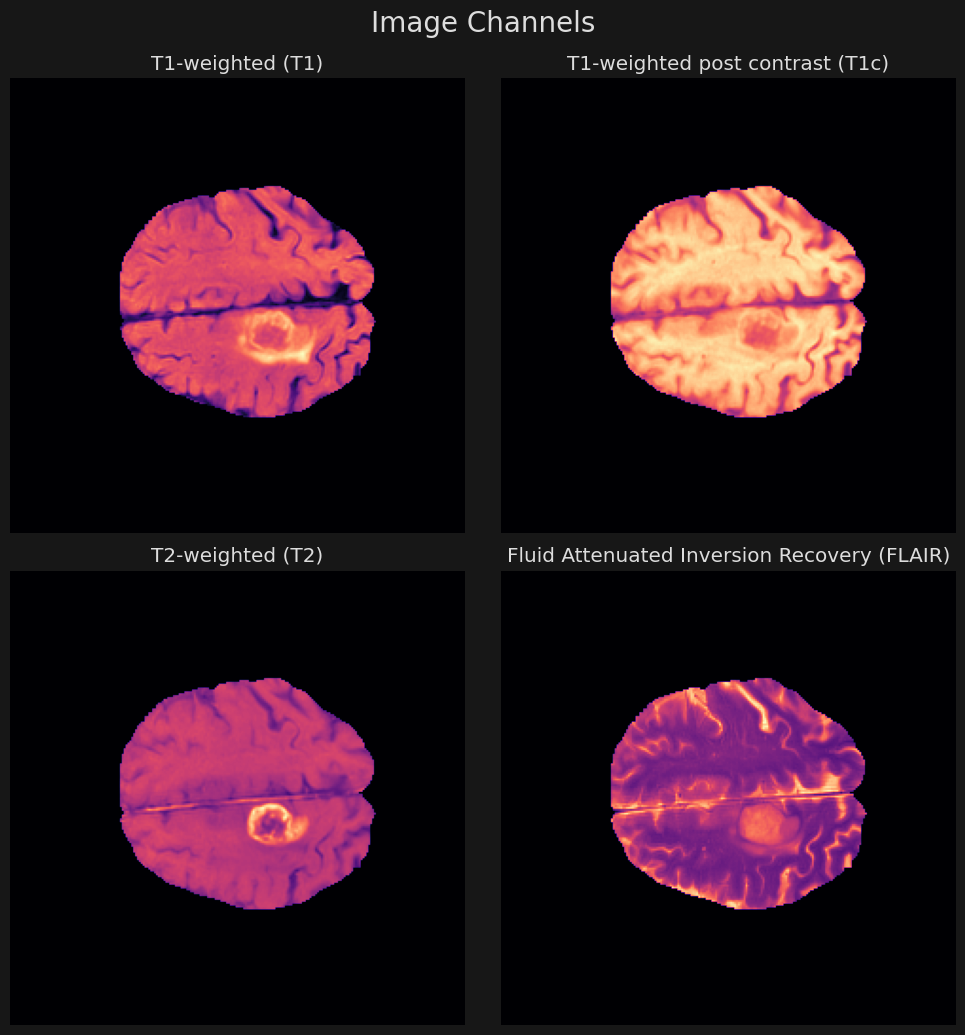

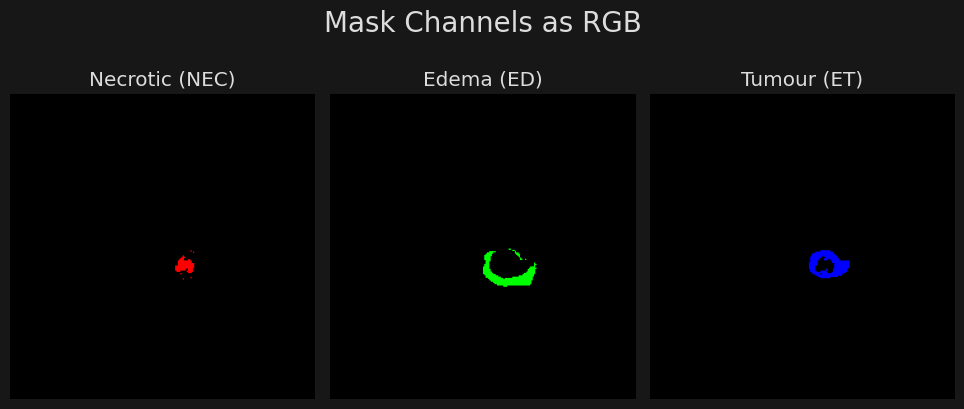

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
# overlay_masks_on_image(image, mask)

Наш датасет относительно большой - ~8GB, поэтому возпользуемся dataloader для загрузки пар данных батчами. Посколько данные формат данных нестандартный, нам нужно написать свой собственный Dataset object и DataLoader. 

Изображения сохранены в формате `float64` с интенсивностью пикселя от ~-0.5 до ~230 и `height`, `width`, `channels` последовательностью каналов. Маски сохраннены в `uint8` и пиксели там представлены 0 и 1. 

Наш Dataset должен загрузить изображение, зарешейпить его в  `channels`, `height`, `width`, поправить значения пикселей чтобы минимум был в 0 на каждом изображении, затем каждый канал, чтобы максимум был 1, затем сконвертировать в  `torch.float32` tensor.

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image =  image.transpose(2, 0, 1)
            mask =  mask.transpose(2, 0, 1)
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                diff = image[i, :, :].max() - image[i, :, :].min()
                if diff==0:
                    image[i, :, :] = np.zeros_like(image[i, :, :])
                else:
                    image[i, :, :] = (image[i, :, :] - image[i, :, :].min()) / (image[i, :, :].max() - image[i, :, :].min())
            
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    assert images.shape == torch.Size([5, 4, 240, 240])
    assert masks.shape == torch.Size([5, 3, 240, 240])
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


In [4]:
for images, masks in train_dataloader:
    print(images, masks)
    break

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          

In [5]:
from torch import nn

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.encoder_block = nn.Sequential(
            nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
            ),
            nn.BatchNorm2d(num_features=out_channels), 
            activation,
            nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
            ),
            nn.BatchNorm2d(num_features=out_channels), 
            activation
        )
    def forward(self, x):
        return  self.encoder_block(x) 
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=nn.ReLU()):
        super().__init__()
        self.decoder_block = nn.Sequential(
            nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
            ),
            nn.BatchNorm2d(num_features=out_channels), 
            activation,
            nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
            ),
            nn.BatchNorm2d(num_features=out_channels), 
            activation
        )
    def forward(self, x):
        return  self.decoder_block(x) 

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  =  nn.MaxPool2d(kernel_size=2, stride=2) 
        # self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        self.upsample4 = nn.ConvTranspose2d(n_filters * 16, n_filters * 8, kernel_size=2, stride=2)
        self.upsample3 = nn.ConvTranspose2d(n_filters * 8, n_filters * 4, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(n_filters * 4, n_filters * 2, kernel_size=2, stride=2)
        self.upsample1 = nn.ConvTranspose2d(n_filters * 2, n_filters, kernel_size=2, stride=2)

        # Encoder
        self.enc_block_1 =  EncoderBlock(in_channels, n_filters)
        self.enc_block_2 =  EncoderBlock(n_filters, n_filters * 2)
        self.enc_block_3 =  EncoderBlock(n_filters * 2, n_filters * 4)
        self.enc_block_4 =  EncoderBlock(n_filters * 4, n_filters * 8)   
        
        # Bottleneck
        self.bottleneck  = nn.Sequential(
            nn.Conv2d(
            in_channels=n_filters * 8,
            out_channels=n_filters * 16,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=n_filters * 16),
        activation, 
        nn.Conv2d(
            in_channels=n_filters * 16,
            out_channels=n_filters * 16,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=n_filters * 16),
        activation 
        )
        
        # Decoder
        self.dec_block_4 =  DecoderBlock(n_filters * 16, n_filters * 8)
        self.dec_block_3 =  DecoderBlock(n_filters * 8, n_filters * 4)
        self.dec_block_2 =  DecoderBlock(n_filters * 4, n_filters * 2)
        self.dec_block_1 =  DecoderBlock(n_filters * 2, n_filters)
        
        # Output projection
        self.output = nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)


    def forward(self, x):
        # Encoder
        residual1 = self.enc_block_1(x) 
        x = self.downsample(residual1)    
        residual2 = self.enc_block_2(x) 
        x = self.downsample(residual2)    
        residual3 = self.enc_block_3(x) 
        x = self.downsample(residual3) 
        residual4 = self.enc_block_4(x) 
        x = self.downsample(residual4) 
        x = self.bottleneck(x)

        # Decoder
        x = self.upsample4(x)
        x = torch.cat((x, residual4), dim=1)
        x = self.dec_block_4(x)
        x = self.upsample3(x)
        x = torch.cat((x, residual3), dim=1)
        x = self.dec_block_3(x)
        x = self.upsample2(x)
        x = torch.cat((x, residual2), dim=1)
        x = self.dec_block_2(x)
        x = self.upsample1(x)
        x = torch.cat((x, residual1), dim=1)
        x = self.dec_block_1(x)
        x = self.output(x)
        return x.squeeze()
    
# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, train_config, path='model_weights.pth'):
    torch.save({**train_config, **{'model_state_dict':model.state_dict()}}, path)

### Training Loop


In [6]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [7]:
from tqdm import tqdm

def train_model(
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    train_config: dict,
):
    model=train_config["model"]
    optimizer=train_config["optimizer"]
    scheduler=train_config["scheduler"]
    train_dataloader=train_dataloader
    val_dataloader=val_dataloader
    n_epochs=train_config["n_epochs"]
    learning_rate=train_config["learning_rate"]
    lr_lambda=train_config["lr_lambda"]
    batches_per_epoch_ratio=train_config["batches_per_epoch_ratio"]
    verbose=train_config["verbose"]
    
    loss_decreases = []
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    optimizer = optimizer(model.parameters(), lr=learning_rate)
    scheduler = scheduler(optimizer, lr_lambda=lambda epoch: lr_lambda)
    batches_per_epoch = int(batches_per_epoch_ratio * len(train_dataloader))

    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []

    print("Training...")
    for epoch in tqdm(range(1, n_epochs + 1)):
        current_lr = scheduler.get_last_lr()

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose:
                print(
                    f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}",
                    end="",
                )
            train_inputs, train_targets = train_inputs.to(device), train_targets.to(
                device
            )
            train_preds = model(train_inputs)
            # print(train_preds.shape, train_targets.shape)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                if verbose:
                    print()
                break
        train_epoch_losses.append(train_epoch_loss / batches_per_epoch)
        scheduler.step()

        # Val step
        model.eval()
        val_epoch_loss = 0
        for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
            if verbose:
                print(
                    f"\rEpoch: {epoch}, Train loss: {train_epoch_loss/train_batch_idx:.6f}, Val loss: {val_epoch_loss/val_batch_idx:.6f}, lr {float(current_lr[0]):.6f}",end=''
                )   
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_preds = model(val_inputs)
            val_batch_loss = loss_fn(val_preds, val_targets)
            val_epoch_loss += val_batch_loss.item()
            # if val_batch_idx >= batches_per_epoch:
            #     if verbose:
            #         print()
            #     break
        
        val_epoch_losses.append(val_epoch_loss / len(val_dataloader))
        if epoch==1:
            loss_decreases.append(1)
        elif epoch<=3:
            if val_epoch_losses[-1] < val_epoch_losses[-1]:
                loss_decreases.append(1)
            else:
                loss_decreases.append(0)
        else:
            if sum(loss_decreases[-3:])==0:
                break
        
            
    print(f'Было эпох: {epoch}')
    save_model(model=model, train_config=train_config, path=f'model_weights_{epoch}_epochs.pth')
    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [8]:
train_config = {
    "model": UNet(),
    "optimizer": torch.optim.Adam,
    "scheduler": torch.optim.lr_scheduler.MultiplicativeLR,
    "n_epochs": 10,
    "learning_rate": 1e-3,
    "lr_lambda": 0.85,
    "batches_per_epoch_ratio": 0.999,
    "train_batch_size": 6,
    "val_batch_size": 6,
    "verbose": True
}

# Create UNet model and count params
model = UNet()
count_parameters(model)  

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config["train_batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config["val_batch_size"], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    train_config=train_config,
)

Total Parameters: 7,766,339

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Train batch: 8571/8571, Avg batch loss: 0.013440
Epoch: 1, Train loss: 0.013440, Val loss: 0.005991, lr 0.001000

 10%|█         | 1/10 [32:29<4:52:27, 1949.68s/it]

Train batch: 8571/8571, Avg batch loss: 0.00510391, lr 0.001000
Epoch: 2, Train loss: 0.005103, Val loss: 0.005422, lr 0.000850

 20%|██        | 2/10 [58:16<3:48:21, 1712.74s/it]

Train batch: 8571/8571, Avg batch loss: 0.004350
Epoch: 3, Train loss: 0.004350, Val loss: 0.004578, lr 0.000722

 30%|███       | 3/10 [1:33:34<3:41:23, 1897.65s/it]

Train batch: 8571/8571, Avg batch loss: 0.003652
Epoch: 4, Train loss: 0.003653, Val loss: 0.003438, lr 0.000614

 40%|████      | 4/10 [2:06:00<3:11:41, 1916.86s/it]

Train batch: 8571/8571, Avg batch loss: 0.00313837, lr 0.000614
Epoch: 5, Train loss: 0.003138, Val loss: 0.003117, lr 0.000522

 50%|█████     | 5/10 [2:37:35<2:39:04, 1908.82s/it]

Train batch: 8571/8571, Avg batch loss: 0.00280816, lr 0.000522
Epoch: 6, Train loss: 0.002808, Val loss: 0.002839, lr 0.000444

 60%|██████    | 6/10 [3:08:59<2:06:41, 1900.36s/it]

Train batch: 8571/8571, Avg batch loss: 0.002544
Epoch: 7, Train loss: 0.002545, Val loss: 0.002553, lr 0.000377

 70%|███████   | 7/10 [3:40:31<1:34:53, 1897.75s/it]

Train batch: 8571/8571, Avg batch loss: 0.00234049, lr 0.000377
Epoch: 8, Train loss: 0.002340, Val loss: 0.002352, lr 0.000321

 80%|████████  | 8/10 [4:04:58<58:41, 1760.51s/it]  

Train batch: 8571/8571, Avg batch loss: 0.00218052, lr 0.000321
Epoch: 9, Train loss: 0.002180, Val loss: 0.002294, lr 0.000272

 90%|█████████ | 9/10 [4:29:26<27:49, 1669.13s/it]

Train batch: 8571/8571, Avg batch loss: 0.00204094, lr 0.000272
Epoch: 10, Train loss: 0.002041, Val loss: 0.002103, lr 0.000232

100%|██████████| 10/10 [4:53:51<00:00, 1763.18s/it]

Было эпох: 10
Training complete.


In [9]:
train_epoch_losses, val_epoch_losses

([0.013440268594371443,
  0.005103241219874641,
  0.004349602771874431,
  0.0036528301498603344,
  0.0031384045496378535,
  0.0028078544385382116,
  0.0025447566090249277,
  0.0023395487699321487,
  0.0021798965062553794,
  0.0020405235454632516],
 [0.006025381203465428,
  0.005454542115616761,
  0.0046202888487243375,
  0.0034507619351282527,
  0.003121801316144369,
  0.002842249765842219,
  0.002553731098670257,
  0.0023562477297207995,
  0.0022970029806273023,
  0.002105729792664766])

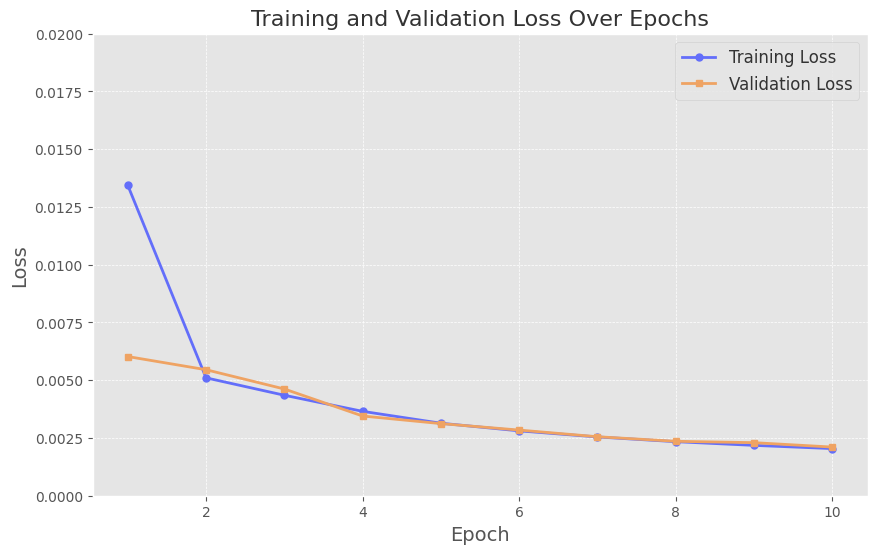

In [15]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 0.02)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

1.7884008e-15 0.99971026 814.54614
0.0 1.0 817.0


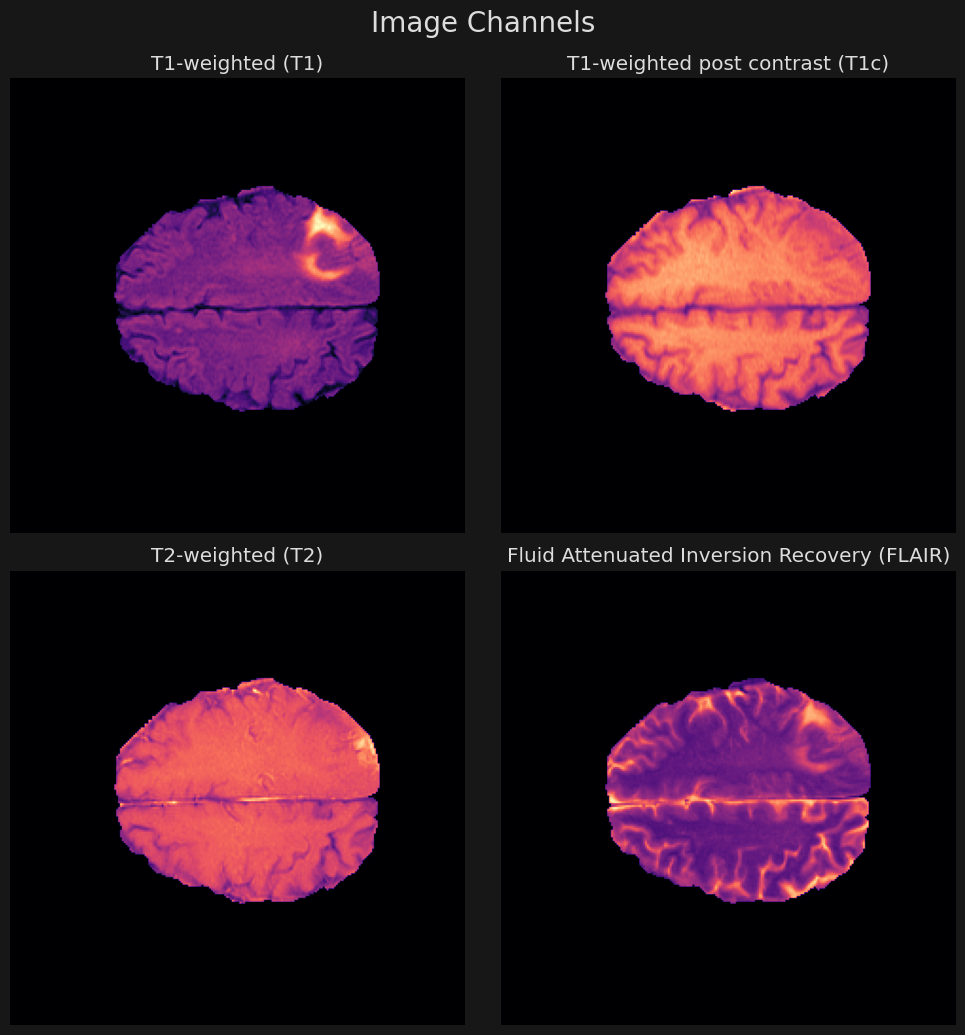

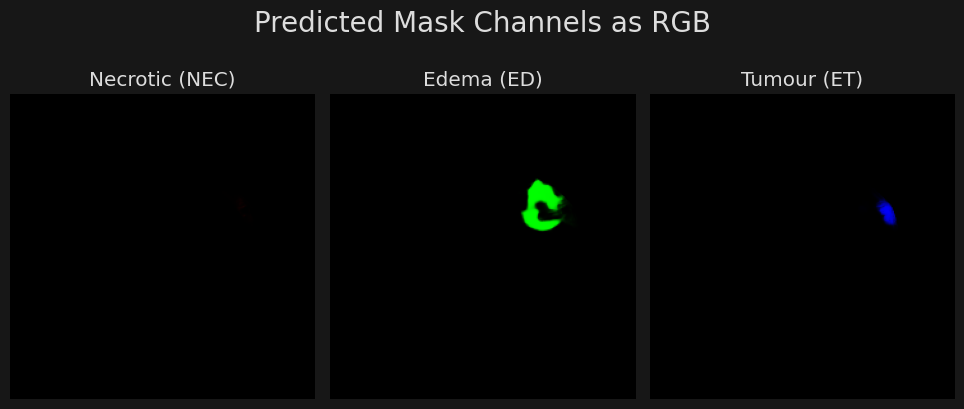

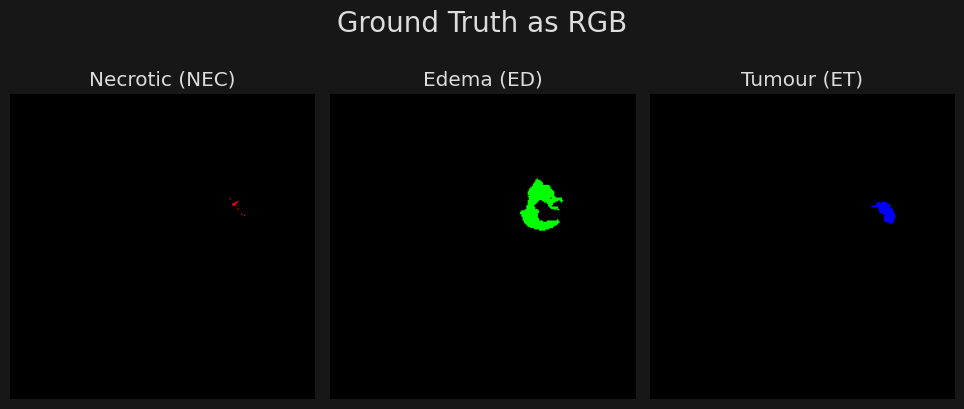

In [16]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze()
    mask_pred = test_pred.detach().cpu().numpy().squeeze()
    mask_target = test_target.detach().cpu().numpy().squeeze()
    print(mask_pred.min(), mask_pred.max(), mask_pred.sum())
    print(mask_target.min(), mask_target.max(), mask_target.sum())
    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(train_config["model"], test_input, test_target, device)

1.697964e-16 0.9995521 1902.9597
0.0 1.0 1905.0


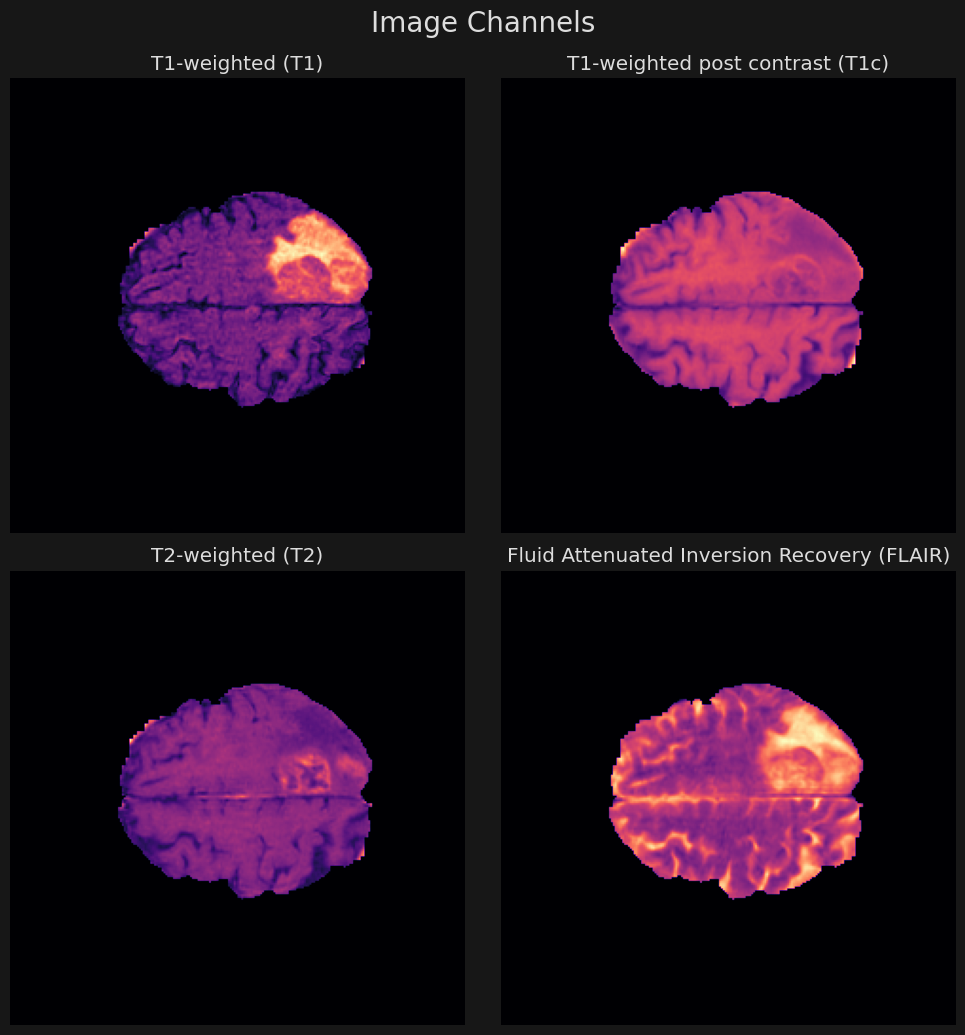

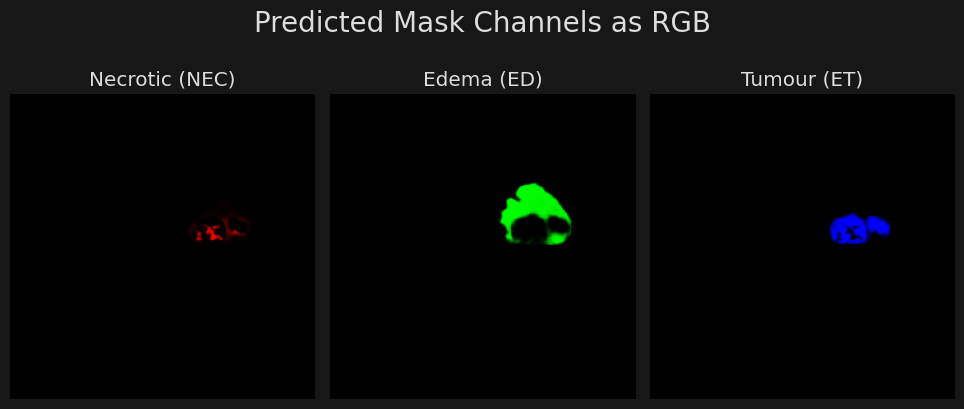

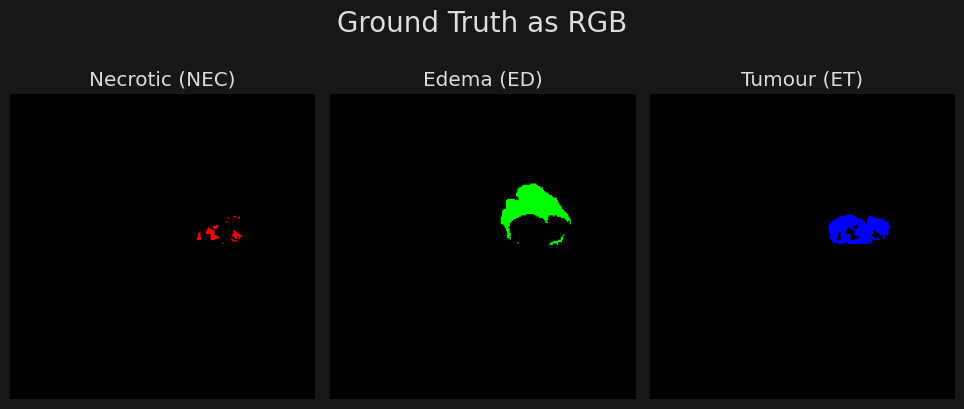

In [20]:
test_input, test_target = next(test_input_iterator)

display_test_sample(train_config["model"], test_input, test_target, device)